**Approach 1 - Tf-Idf and BOW**<br>
**RUN THIS CELL IF RUNNING IN GOOGLE COLAB**

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Automatic Ticket Assignment')
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from Model.ModelTuningAndEvaluation import evaluation_metrics
from DataTransformation.DataVectorizer import data_vectorizer
from ProjectModules.PlottingModule import plot_count_plot
from sklearn.ensemble import RandomForestClassifier

installing wordcloud python package...
Done!


In [ ]:
# RUN THIS DATAPATH IF RUNNING IN GOOGLE COLAB, GIVE THE CORRECT PATH TO THE DATA
DATAPATH = '/content/drive/MyDrive/Automatic Ticket Assignment/DataFiles/'
# *************************** --------------------------************************************
# DATAPATH = 'DataFiles/'

data = pd.read_csv(DATAPATH+"processed_data.csv")
df = data.copy() #making copy of the data
print(df.shape)
df.head()

(7877, 3)


,cleaned_short_desc,cleaned_desc,Assignment group
0,login issue,verify user detail employee manager name check...,GRP_0
1,outlook,team meeting skype meeting etc appear outlook ...,GRP_0
2,cant log vpn,cannot log vpn best,GRP_0
3,unable access hr tool page,unable access hr tool page,GRP_0
4,skype error,skype error,GRP_0


In [ ]:
print("We saw earlier that we have "+str(df["Assignment group"].nunique())+" labels in the target variable")

We saw earlier that we have 74 labels in the target variable


In [ ]:
df.isnull().sum()

cleaned_short_desc    16
cleaned_desc          52
Assignment group       0
dtype: int64

**we can see some missing values but remember that we removed only those records that had missing values in both description and short description columns. If either of the two had text, we retained it<br>
The missing text was saved with an empty string in the dataframe during pre-processing, but when we converted it to csv and loaded it again, the empty strings display with NaN**<br>If you'll see there is no record where both description and short description is missing: 

In [ ]:
df[(df['cleaned_short_desc'].isnull()) & (df['cleaned_desc'].isnull())]

,cleaned_short_desc,cleaned_desc,Assignment group


So lets fill NaNs with empty string again

In [ ]:
df['cleaned_short_desc'].fillna(value="",inplace=True)
df['cleaned_desc'].fillna(value = "",inplace=True)

**As stated above, the first method that we'll be taking up is transforming the sequences into tf-idf and bag of words matrices, hence we will combine the cleaned_desc and cleaned_short_desc column into one column named "combined_tokens"**

In [ ]:
df["combined_tokens"] = df["cleaned_short_desc"] +" "+ df["cleaned_desc"]
df.head()

,cleaned_short_desc,cleaned_desc,Assignment group,combined_tokens
0,login issue,verify user detail employee manager name check...,GRP_0,login issue verify user detail employee manage...
1,outlook,team meeting skype meeting etc appear outlook ...,GRP_0,outlook team meeting skype meeting etc appear ...
2,cant log vpn,cannot log vpn best,GRP_0,cant log vpn cannot log vpn best
3,unable access hr tool page,unable access hr tool page,GRP_0,unable access hr tool page unable access hr to...
4,skype error,skype error,GRP_0,skype error skype error


**Before moving ahead, in analysis and pre-processing we saw that 6 target classes had only 1 record. Lets refresh our memories:**

Last 26 records
GRP_53    11
GRP_52     9
GRP_55     8
GRP_51     8
GRP_46     6
GRP_59     6
GRP_49     6
GRP_43     5
GRP_66     4
GRP_32     4
GRP_63     3
GRP_38     3
GRP_56     3
GRP_58     3
GRP_68     3
GRP_57     2
GRP_72     2
GRP_69     2
GRP_54     2
GRP_71     2
GRP_67     1
GRP_61     1
GRP_73     1
GRP_64     1
GRP_35     1
GRP_70     1
Name: Assignment group, dtype: int64 



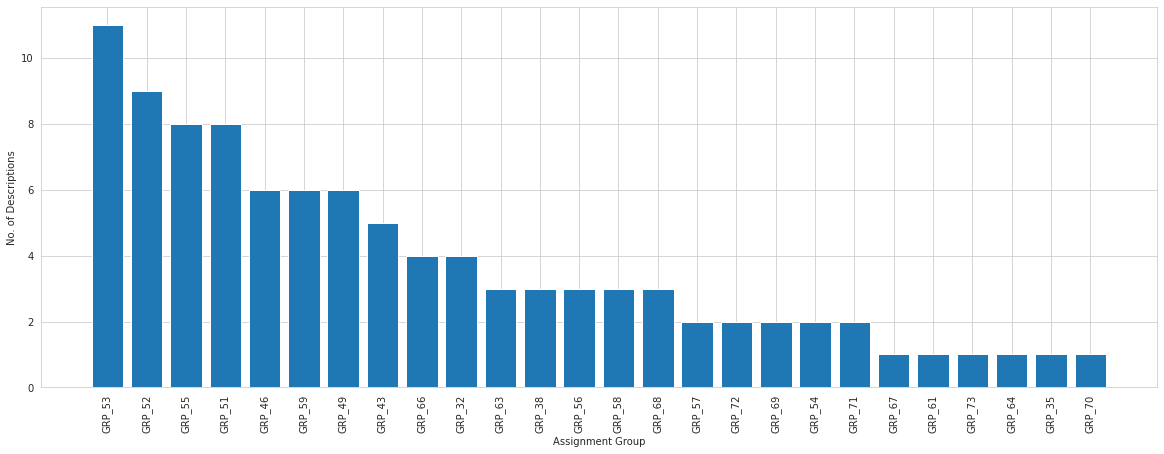

In [ ]:
xlabel = "Assignment Group"
ylabel = "No. of Descriptions"
values = df["Assignment group"].value_counts().tail(26).to_dict().values()
labels = df["Assignment group"].value_counts().tail(26).to_dict().keys()
print("Last 26 records")
print(df["Assignment group"].value_counts().tail(26),"\n")
plot_count_plot(values,labels,xlabel,ylabel)

If you see the last 6 records, they have only one ticket assigned to each of them. As a result of this, we will not be able to split in a stratified fashion. A stratified split means to split in train and test split such that the target class distribution is retained. Eg: If the target class had 3 labels: A(75%), B(20%) and C(5%), then the train and test sets, both will have the same proportion of A, B and C as in the original dataset. Now, to make a stratified split, every target class label (in our case assignment group) must have atleast 2 records, so that it can be sent in both the test and train set. However, what we see is that 6 of our labels have only 1 record.<br><br>
**WHY DO WE HAVE TO HAVE A STRATIFIED SPLIT ?**<BR>
We'll have a problem while calculating the ROC AUC of the multiclass labels. We need to have a startified split to ensure that both the sets (train and test) have all the target classes. Eg: Lets say after splitting without stratify, our train set has datapoints belonging to these 5 classes; A, B, C, D and E and test set has datapoints belonging to only A, C, D and E. Since we'll train on the train set and predict on the test set; it is very likely that atleast one of the test data points will be predicted as B, but there is no B in the test labels. This will cause error while calculating the ROC AUC or other evaluation metrics<br><br>
**Now to overcome this issue** we will slightly upsample some of our minority classes. If you'll look at the last 26 records in the above graph, group 53 has 11 tickets assigned and except that all other groups have less than 10 tickets assigned to it. Hence we will upsample all the groups having less than 10 tickets to 10. With this upsampling, each group will be upsampled to 10 simply by duplicating the datapoints in that group.<br><br>**Below we define our sampling strategy: Last 25 groups will be upsampled to 10**

In [ ]:
last25records = df["Assignment group"].value_counts().tail(25).keys().to_list()
upsample_strategy = {i:10 for i in last25records}
upsample_strategy   

{'GRP_32': 10,
 'GRP_35': 10,
 'GRP_38': 10,
 'GRP_43': 10,
 'GRP_46': 10,
 'GRP_49': 10,
 'GRP_51': 10,
 'GRP_52': 10,
 'GRP_54': 10,
 'GRP_55': 10,
 'GRP_56': 10,
 'GRP_57': 10,
 'GRP_58': 10,
 'GRP_59': 10,
 'GRP_61': 10,
 'GRP_63': 10,
 'GRP_64': 10,
 'GRP_66': 10,
 'GRP_67': 10,
 'GRP_68': 10,
 'GRP_69': 10,
 'GRP_70': 10,
 'GRP_71': 10,
 'GRP_72': 10,
 'GRP_73': 10}

In [ ]:
# saving names of the feature columns
featnames = list(df.columns[:2]) + list(df.columns[3:])

# seperating features and target
targetcolumn = df["Assignment group"].values
feats = df.drop(['Assignment group'],axis=1).values

# initializing RandomOverSampler
oversample = RandomOverSampler(sampling_strategy=upsample_strategy, random_state=7)
others_up, target_up = oversample.fit_resample(X=feats,y=targetcolumn)
others_up = pd.DataFrame(others_up,columns=featnames)
target_up = pd.DataFrame(target_up,columns=["Assignment group"])

# concatinating features and target after upsampling
df = pd.concat([others_up,target_up],axis=1)
print("dataset size after upsampling:",df.shape[0])
df.head()

dataset size after upsampling: 8040


,cleaned_short_desc,cleaned_desc,combined_tokens,Assignment group
0,login issue,verify user detail employee manager name check...,login issue verify user detail employee manage...,GRP_0
1,outlook,team meeting skype meeting etc appear outlook ...,outlook team meeting skype meeting etc appear ...,GRP_0
2,cant log vpn,cannot log vpn best,cant log vpn cannot log vpn best,GRP_0
3,unable access hr tool page,unable access hr tool page,unable access hr tool page unable access hr to...,GRP_0
4,skype error,skype error,skype error skype error,GRP_0


**Now we can see that none of the groups have just 1 ticket. All the groups that had <=9 tickets have been upsampled to 10. Printing last 26 records again**

Last 26 records after upsampling
GRP_53    11
GRP_56    10
GRP_57    10
GRP_43    10
GRP_73    10
GRP_55    10
GRP_64    10
GRP_54    10
GRP_66    10
GRP_35    10
GRP_52    10
GRP_38    10
GRP_68    10
GRP_61    10
GRP_67    10
GRP_63    10
GRP_72    10
GRP_69    10
GRP_51    10
GRP_49    10
GRP_59    10
GRP_58    10
GRP_71    10
GRP_70    10
GRP_46    10
GRP_32    10
Name: Assignment group, dtype: int64 



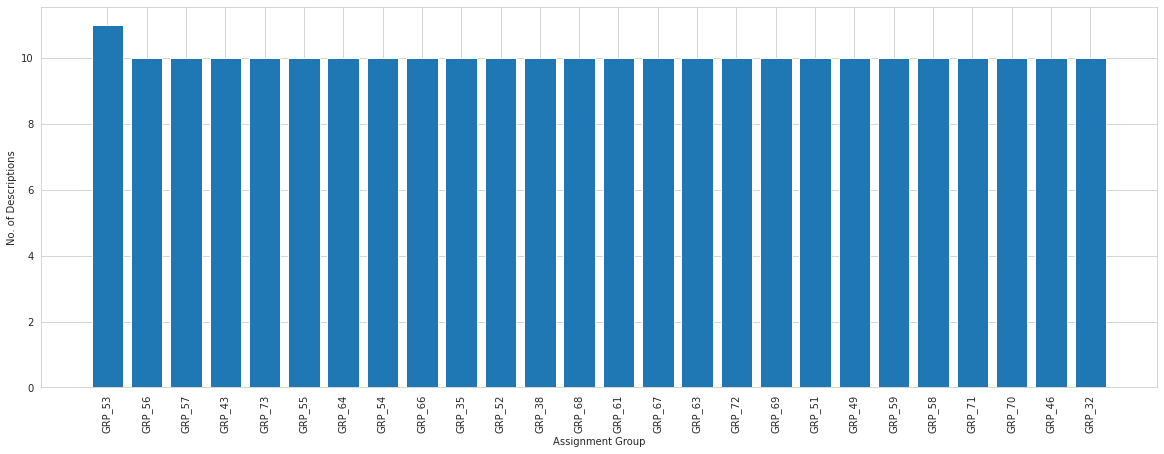

In [ ]:
xlabel = "Assignment Group"
ylabel = "No. of Descriptions"
values = df["Assignment group"].value_counts().tail(26).to_dict().values()
labels = df["Assignment group"].value_counts().tail(26).to_dict().keys()
print("Last 26 records after upsampling")
print(df["Assignment group"].value_counts().tail(26),"\n")
plot_count_plot(values,labels,xlabel,ylabel)

lets save this upsampled data:

In [ ]:
# # USE THIS SAVEPATH IF RUNNING IN GOOGLE COLAB, GIVE THE PATH WHERE YOU WANT TO SAVE
# SAVEPATH = '/content/drive/MyDrive/Automatic Ticket Assignment/DataFiles/'
# # *************************** --------------------------************************************
# # SAVEPATH = 'DataFiles/'

# df.to_csv(SAVEPATH+"upsampled_processed_data.csv",index=False)

**and we can thus make a stratified 80:20 split:**

In [ ]:
x = df["combined_tokens"].values
y = df["Assignment group"].values

# label encoding the target column
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
print("encoded_classes:\n",le.classes_)

encoded_classes:
 ['GRP_0' 'GRP_1' 'GRP_10' 'GRP_11' 'GRP_12' 'GRP_13' 'GRP_14' 'GRP_15'
 'GRP_16' 'GRP_17' 'GRP_18' 'GRP_19' 'GRP_2' 'GRP_20' 'GRP_21' 'GRP_22'
 'GRP_23' 'GRP_24' 'GRP_25' 'GRP_26' 'GRP_27' 'GRP_28' 'GRP_29' 'GRP_3'
 'GRP_30' 'GRP_31' 'GRP_32' 'GRP_33' 'GRP_34' 'GRP_35' 'GRP_36' 'GRP_37'
 'GRP_38' 'GRP_39' 'GRP_4' 'GRP_40' 'GRP_41' 'GRP_42' 'GRP_43' 'GRP_44'
 'GRP_45' 'GRP_46' 'GRP_47' 'GRP_48' 'GRP_49' 'GRP_5' 'GRP_50' 'GRP_51'
 'GRP_52' 'GRP_53' 'GRP_54' 'GRP_55' 'GRP_56' 'GRP_57' 'GRP_58' 'GRP_59'
 'GRP_6' 'GRP_60' 'GRP_61' 'GRP_62' 'GRP_63' 'GRP_64' 'GRP_65' 'GRP_66'
 'GRP_67' 'GRP_68' 'GRP_69' 'GRP_7' 'GRP_70' 'GRP_71' 'GRP_72' 'GRP_73'
 'GRP_8' 'GRP_9']


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=777, stratify=y)

print("train set",x_train.shape,"\n")
print("test set",x_test.shape)

train set (6432,) 

test set (1608,)


**Converting to bow and tf-idf:**<br>
In both cases<br>
- we will take max_df = 0.80 i.e if a word appears in more than 80% of the records it will be ignored<br>
- we will take max_feat = 2000 i.e consider only top 2000 words in the vocabulary based on their term frequency<br>

**To know more, please refer the docstring of the function**

In [ ]:
print(data_vectorizer.__doc__)


  Converts the train and test set into BagOfWords or Tf-Idf matrix. Returns two arrays for train set and test set
  of size (document size,max_feat)
  
  xtr: train set (array)

  xte: test set (array)

  maxdf: ignores terms/words that have a document frequency higher than 'maxdf'. In other words, it ignores terms that
  appear in more than 'maxdf' number of documents/records. Give value between 0 and 1. Default value = 0.6(60%)

  max_feat: builds a vocabulary considering only top "max_features" ordered by term frequency across the corpus. Default value = 1000

  vectorizer: enter 'bow' for bag of words transformation or 'tfidf' for Tf-Idf transformation. Default value = 'bow' (string)
  


In [ ]:
x_train_bow, x_test_bow = data_vectorizer(xtr=x_train,xte=x_test,maxdf=0.80,max_feat=2000)

print("Bag Of Words")
print("train set",x_train_bow.shape,"\n")
print("test set",x_test_bow.shape)

Bag Of Words
train set (6432, 2000) 

test set (1608, 2000)


In [ ]:
x_train_tfidf, x_test_tfidf = data_vectorizer(xtr=x_train,xte=x_test,maxdf=0.80,max_feat=2000,vectorizer="tfidf")

print("Tfidf")
print("train set",x_train_tfidf.shape,"\n")
print("test set",x_test_tfidf.shape)

Tfidf
train set (6432, 2000) 

test set (1608, 2000)


**Trying base models:**<br><br>
**LinearSVC**, **Logistic Regression** and **Random Forest** will be the first set of base models of our choice<br>
- Although we are using Random Forest model but it is expected that it wont be as good as our other two choices because theoretically tree based models flunk in higher dimensions and we have a massive dimensionality of 2000 after Tf-Idf and BOW data transformation<br>
- Also k-nearest neighbors may or may not work but given the size of the dataset and the dimensions training KNN's would be painfully slow. Hence training a KNN model is not computationally viable<br>
- Naive Bayes can also be ignored in this use case even though it performs in higher dimensions because we have a highly skewed target class. High skewness especially affects Naive Bayes because prior probability of minority class tends to be zero<br>


**Note that we are using LinearSVC instead of classical SVC with different kernals since they will be computationally expensive to train as well. Some key differences that make LinearSVC faster is as follows:**<br>
- For multi-class classification problem SVC fits N * (N - 1) / 2 models where N is the amount of classes. LinearSVC, by contrast, simply fits N models<br>
- The underlying estimator for LinearSVC is liblinear while SVC uses libsvm estimator. liblinear estimators are optimized for a linear case and thus converge faster on big amounts of data than libsvm. That is why LinearSVC takes less time to solve the problem.
- In practice the complexity of the SVC algorithm (that works both for kernel and linear SVC) as implemented in libsvm is O(n^2) or O(n^3) whereas liblinear is O(n) but it does not support kernel SVCs.

**Also as we mentioned before, we will be calculating ROC_AUC for the models which requires us to predict class probabilities.** Logistic Regression by default calculates probabilities which can be obtained simply by predict_proba() but SVM's do not. SVC can calculate the probabilities if we set probability = True but LinearSVC does not have support for this. Hence to obtain probabilities for LinearSVM we will be wrapping it inside a CalibratedClassifier<br><br>
**How does it calibrate?**<br>
First it finds probabilities with which LinearSVC classifies (The same way regular SVC does when we set probability = True). This is done by calculating p(j|x) i.e given a sample x, knowing its distance from the
separating hyperplane and the class to which it belongs, it finds the probability with which x belongs to class j<br>Then the CalibratedClassifier further calibrates these probabilities by fitting a regressor that maps the output of the classifier (LinearSVC) to the calibrated probability between 0 and 1. In simpler words, it tries to predict p(yi=1|x) for a sample x<br><br><hr>

**Now lets have a look at our evaluation metric.** We will print f1-score, accuracy as well as ROC-AUC score. Ideally, ROC-AUC is for binary classification but it can be modified for multi-class as well. Below is our function for printing Accuracy, AUC and f1-score imported from ModelTuningAndEvaluation.py file:

In [ ]:
print(evaluation_metrics.__doc__)


  Prints Accuracy, F1-Score and ROC-AUC score using Sklearn. Since we have multiclass classification you will need to specify 
  multi-class strategy and averaging strategy.
  NOTE THAT: 
  - ROC-AUC only support macro averaging; while f1-score supports both macro and micro
  - F1-score does not have multi-class parameter hence it does not take 'ovo' or 'ovr' into account. ROC-AUC supports multiclass
  - Accuracy is independent of these two parameters. They are not applicable to accuracy

  ytrue: true labels (array/list/series)
  ypred_proba: predicted probabilities (array/list/series)
  multiclass: multi-class strategy; enter 'ovr' for OneVsRest and 'ovo' for OneVsOne (string)
  avg: averaging strategy; accepts 'micro', 'macro' and 'weighted' (string)
  


As we can see, it takes two special arguments; **'multiclass'** and **'avg'**<br><br> **multiclass argument** can take 2 string values: 'ovr' which implements OneVsRest and 'ovo' which implements OneVsOne. 'ovr' can be implemented with models that natively support multi-class classification like logistic regression, neural networks etc. while 'ovo' can be used with others as well. Especially, 'ovo' is preferred for SVM's and other kernel methods because these methods does not scale in proportion to the size of the training dataset and takes a large amount of time to train when dataset is huge. Hence for these methods we train dataset in subsets which may affect the evaluation metrics. **Hence we will use 'ovo' for our use case**<br><br>**avg argument** can take 3 string values: "micro", "macro" and "weighted". We will focus on micro and macro mainly<br>**Micro:** lets look at micro averaging with an example. Say we are calculating precision for a multiclass problem. Precision is calculated by TP/TP+FP. Now since we have a multi class problem we will have TP's and FP's for every class. Hence the average precision with 'micro' is given by (sum of all TP's)/(sum of all TP's) + (sum of all FP's) i.e (TP1+TP2+...+TPn)/(TP1+TP2+...+TPn) + (FP1+FP2+...+FPn)<br>Similarly, Recall will be calculated with the same averaging technique<br>**Macro:** macro averaging on the other hand is pretty straight forward. Again taking the example of precision, it calculates precision individually for each class and averages it. Eg: Lets say we have 'n' classes. Therefore we will have 'n' precision scores (p1, p2, p3...., pn). Now the average precision score would be (p1+p2+p3+...+pn)/n<br>Similarly, Recall will be calculated with the same averaging technique<br><br>**When we have balanced classes micro and macro metrics will be almost similar, however when we have class imbalance, macro averaging will always be less than micro; since the metric calculated for each class is individually averaged. So lets say if a particular class has very low recall (or precision) compared to other classes, the mean will be affected because of that class and will decrease**<br><br>
**Also according to the sklearn's documentation... when micro averaging, micro F1-Score = micro precision = micro Recall = Accuracy in case of multi-class classification where a datapoint belongs to exactly 1 class. This behaviour can be explained with a simple example:**<br>Precision = tp/tp+fp and Recall = tp/tp+fn. So numerator is same. In denominator we have, fp and fn. Now, fn with respect to one class is same as fp with respect to another class, hence fp=fn, and so now denominator is also same. Therefore precision = Recall and thus harmonic mean between the two i.e f1-score will also be same in case of micro-averaging. **Now if we micro-average, say for 'n' classes**, The formula would be:<br>micro precision = [(tp1+tp2+tp3+...+tpn)/(tp1+tp2+tp3+...+tpn) + (fp1+fp2+fp3+...+fpn)] = [(tp1+tp2+tp3+...+tpn)/(tp1+tp2+tp3+...+tpn) + (fn1+fn2+fn3+...+fnn)]<br>**Since fp=fn; the denominator becomes all positives + allnegatives i.e total number of samples** and **numerator is all positives (tp) i.e all correctly classified samples.** So all **all correctly classified/total no. of samples = accuracy.** Thus in micro-averaging, F1-Score = micro precision = micro Recall = Accuracy
<br><br>"*In a broad sense, 'micro' gives the overall performance of the model despite having class imbalance while 'macro' takes into account the effects minority classes and gives the performance accordingly. Hence we will monitor macro metrics i.e macro ROC-AUC and macro F1-Score ----and---- accuracy since it will give the overall performance of the model and is equal to micro metrics*"<br>**NOTE THAT:**<br>
- ROC-AUC only support macro averaging; while f1-score supports both macro and micro<br>
- F1-score does not have multiclass parameter hence it does not take 'ovo' or 'ovr' into account but ROC-AUC supports multiclass parameter hence we'll be using 'ovo'<br>
- Accuracy is independent of these two parameters. They are not applicable to accuracy. But since accuracy will give the micro performance (i.e overall performance of the model despite class imbalance), we will monitor it too

<br><br>
**LinearSVC with calibration:**<br>
Predicting on BOW transformation

In [ ]:
model = LinearSVC(random_state=111)

# pre-fitting LinearSVC and then wrapping it in the calibrated classifier
model.fit(x_train_bow,y_train)
calibrated_model = CalibratedClassifierCV(model, cv="prefit")

# calibrating probabilities on the train set. Note that the svm has already been pre-fitted
calibrated_model.fit(x_train_bow,y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None,
                                                dual=True, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=111, tol=0.0001,
                                                verbose=0),
                       cv='prefit', method='sigmoid')

In [ ]:
# predicting probabilities on the train and test set
tr_pred_bow = calibrated_model.predict_proba(x_train_bow)
te_pred_bow = calibrated_model.predict_proba(x_test_bow)

print("Train set performance:")
evaluation_metrics(y_train, tr_pred_bow, "ovo", "macro")

print("\nTest set performance:")
evaluation_metrics(y_test, te_pred_bow, "ovo", "macro")

print("\n**As explained above - micro-metrics will be similar to accuracy")

Train set performance:
Accuracy: 0.9365671641791045
(macro) ROC-AUC: 0.9994647272462003
(macro) F1 Score: 0.9328508582889518

Test set performance:
Accuracy: 0.6330845771144279
(macro) ROC-AUC: 0.8962155772165858
(macro) F1 Score: 0.4833211924530807

**As explained above - micro-metrics will be similar to accuracy


Predicting on Tf-Idf transformation

In [ ]:
# As before, pre-fitting LinearSVC and then wrapping it in the calibrated classifier
model.fit(x_train_tfidf,y_train)
calibrated_model = CalibratedClassifierCV(model, cv="prefit")

# calibrating probabilities on the train set. Note that the svm has already been pre-fitted
calibrated_model.fit(x_train_tfidf,y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None,
                                                dual=True, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=111, tol=0.0001,
                                                verbose=0),
                       cv='prefit', method='sigmoid')

In [ ]:
# predicting probabilities on the train and test set
tr_pred_tfidf = calibrated_model.predict_proba(x_train_tfidf)
te_pred_tfidf = calibrated_model.predict_proba(x_test_tfidf)

print("Train set performance:")
evaluation_metrics(y_train, tr_pred_tfidf, "ovo", "macro")

print("\nTest set performance:")
evaluation_metrics(y_test, te_pred_tfidf, "ovo", "macro")

print("\n**As explained above - micro-metrics will be similar to accuracy")

Train set performance:
Accuracy: 0.9032960199004975
(macro) ROC-AUC: 0.9988507366827656
(macro) F1 Score: 0.9056044626916231

Test set performance:
Accuracy: 0.6735074626865671
(macro) ROC-AUC: 0.9325336849999616
(macro) F1 Score: 0.5211461780516881

**As explained above - micro-metrics will be similar to accuracy


**LogisticRegression:**<br>
Predicting on BOW transformation

In [ ]:
model = LogisticRegression(random_state=77)
model.fit(x_train_bow,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=77, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# predicting probabilities on train and test set
tr_pred_bow = model.predict_proba(x_train_bow)
te_pred_bow = model.predict_proba(x_test_bow)

print("Train set performance:")
evaluation_metrics(y_train, tr_pred_bow, "ovo", "macro")

print("\nTest set performance:")
evaluation_metrics(y_test, te_pred_bow, "ovo", "macro")

print("\n**As explained above - micro-metrics will be similar to accuracy")

Train set performance:
Accuracy: 0.912157960199005
(macro) ROC-AUC: 0.998952622279794
(macro) F1 Score: 0.903725272502668

Test set performance:
Accuracy: 0.6772388059701493
(macro) ROC-AUC: 0.9422332794435891
(macro) F1 Score: 0.514523393360877

**As explained above - micro-metrics will be similar to accuracy


Predicting on Tf-Idf transformation

In [ ]:
model = LogisticRegression(random_state=77)
model.fit(x_train_tfidf,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=77, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# predicting probabilities on train and test set
tr_pred_tfidf = model.predict_proba(x_train_tfidf)
te_pred_tfidf = model.predict_proba(x_test_tfidf)

print("Train set performance:")
evaluation_metrics(y_train, tr_pred_tfidf, "ovo", "macro")

print("\nTest set performance:")
evaluation_metrics(y_test, te_pred_tfidf, "ovo", "macro")

print("\n**As explained above - micro-metrics will be similar to accuracy")

Train set performance:
Accuracy: 0.6915422885572139
(macro) ROC-AUC: 0.9765793359413277
(macro) F1 Score: 0.31356858754198524

Test set performance:
Accuracy: 0.6305970149253731
(macro) ROC-AUC: 0.9145008549676923
(macro) F1 Score: 0.22749184167268832

**As explained above - micro-metrics will be similar to accuracy


**RandomForest:**<br>
Predicting on BOW transformation

In [ ]:
model = RandomForestClassifier(random_state=7711)
model.fit(x_train_bow,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7711,
                       verbose=0, warm_start=False)

In [ ]:
# predicting probabilities on train and test set
tr_pred_bow = model.predict_proba(x_train_bow)
te_pred_bow = model.predict_proba(x_test_bow)

print("Train set performance:")
evaluation_metrics(y_train, tr_pred_bow, "ovo", "macro")

print("\nTest set performance:")
evaluation_metrics(y_test, te_pred_bow, "ovo", "macro")

print("\n**As explained above - micro-metrics will be similar to accuracy")

Train set performance:
Accuracy: 0.9575559701492538
(macro) ROC-AUC: 0.9994232944288503
(macro) F1 Score: 0.9532052114889993

Test set performance:
Accuracy: 0.6467661691542289
(macro) ROC-AUC: 0.9144724774484881
(macro) F1 Score: 0.4527389240555662

**As explained above - micro-metrics will be similar to accuracy


Predicting on Tf-Idf transformation

In [ ]:
model = RandomForestClassifier(random_state=7711)
model.fit(x_train_tfidf,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7711,
                       verbose=0, warm_start=False)

In [ ]:
# predicting probabilities on train and test set
tr_pred_tfidf = model.predict_proba(x_train_tfidf)
te_pred_tfidf = model.predict_proba(x_test_tfidf)

print("Train set performance:")
evaluation_metrics(y_train, tr_pred_tfidf, "ovo", "macro")

print("\nTest set performance:")
evaluation_metrics(y_test, te_pred_tfidf, "ovo", "macro")

print("\n**As explained above - micro-metrics will be similar to accuracy")

Train set performance:
Accuracy: 0.9572450248756219
(macro) ROC-AUC: 0.9994365413484018
(macro) F1 Score: 0.9526260659402681

Test set performance:
Accuracy: 0.6592039800995025
(macro) ROC-AUC: 0.9226856890065748
(macro) F1 Score: 0.46347841847219884

**As explained above - micro-metrics will be similar to accuracy


### Here we conclude our 1st approach. These were our 1st set of base models with Tf-Idf and BOW transformation of the dataset.<br> In the next part we have our 2nd approach, using a deep learning model that widely benefits sequential modelling; LSTM (part2b)